In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as T
import torchvision.models as models

import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers

In [2]:
from typing import Callable, Any


class NSTDataset(Dataset):
    def __init__(self,
                 content_path: str,
                 style_path: str,
                 transforms: Callable[[Any], Any] | None = None,
                 ):
        super().__init__()

        transforms = transforms or (lambda x: x)
        self.content_img = transforms(cv2.imread(content_path))
        self.style_img = transforms(cv2.imread(style_path))


    def __len__(self):
        return 1

    def __getitem__(self, idx):
        return self.content_img, self.style_img


class DataModule(pl.LightningDataModule):
    def __init__(self, img_sz: (int, tuple), content_path, style_path):
        super().__init__()

        self.transforms = T.Compose([
            T.ToTensor(),
            T.Resize(img_sz),
            T.Lambda(lambda t: torch.clip(t, min=0., max=1.))
        ])

        self.train = NSTDataset(transforms=self.transforms, content_path=content_path, style_path=style_path)

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=1, shuffle=False, num_workers=8, pin_memory=True)

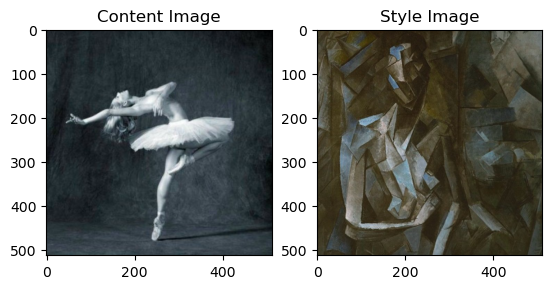

In [3]:
img_sz = 512

dm = DataModule(img_sz=img_sz, content_path='../data/content/dancing.jpg', style_path='../data/style/picasso.jpg')
dm.setup("fit")

con_img, sty_img = dm.train[0]
fix, axes = plt.subplots(1, 2)

axes[0].imshow(np.transpose(con_img, axes=(1, 2, 0)))
axes[0].set_title("Content Image")
axes[1].imshow(np.transpose(sty_img, axes=(1, 2, 0)))
axes[1].set_title("Style Image")
plt.show()

In [4]:
class ExtractFeatureMaps(pl.LightningModule):

    def __init__(self, con_layers: list, sty_layers: list):

        """
        Parameters:
            con_layers: Layers to be used for Content loss
            sty_layers: Layers to be used for Style loss
        """

        super().__init__()

        mapping_dict = {"conv1_1": 0, "conv1_2": 2,
                        "conv2_1": 5, "conv2_2": 7,
                        "conv3_1": 10, "conv3_2": 12, "conv3_3": 14, "conv3_4": 16,
                        "conv4_1": 19, "conv4_2": 21, "conv4_3": 23, "conv4_4": 25,
                        "conv5_1": 28, "conv5_2": 30, "conv5_3": 32, "conv5_4": 34}

        # Normalize the image before passing it through VGG19
        self.transforms = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
        
        self.model = models.vgg19(pretrained=True, progress=True).features  # drop the fully-connected layer
        self.model = self.model.eval()  # put the model in eval mode

        for name, layer in self.model.named_children():
            if isinstance(layer, nn.MaxPool2d):
                self.model[int(name)] = nn.AvgPool2d(kernel_size=2, stride=2)
            if isinstance(layer, nn.ReLU):
                self.model[int(name)] = nn.ReLU(inplace=False)

        self.model.requires_grad_(False)

        self.con_layers = [mapping_dict[layer]  for layer in con_layers] 
        self.sty_layers = [mapping_dict[layer]  for layer in sty_layers]

    def forward(self, x):

        con_feat_maps = []
        sty_feat_maps = []
        x = self.transforms(x).unsqueeze(0)

        for name, layer in self.model.named_children():
            x = layer(x)
            if int(name) in self.con_layers: con_feat_maps.append(x)
            if int(name) in self.sty_layers: sty_feat_maps.append(x)

        return {"Con_feat_maps": con_feat_maps, "Sty_feat_maps": sty_feat_maps}


class Loss(pl.LightningModule):
    def __init__(self, con_target: list, sty_target: list, con_wt: float, sty_wt: float):

        """
        Parameters:
            con_target:    Activation maps of the content image to be used as target
            sty_target:    Activation maps of the style image to be used as target
            con_wt:        Weightage of the content loss in total loss
            sty_wt:        Weightage of the style loss in total loss
        """

        super().__init__()

        self.con_wt = con_wt
        self.sty_wt = sty_wt
        sty_target = [self._gram_matrix(t) for t in sty_target]

        # Register the content and style target as buffers
        [self.register_buffer(f"con_target_{i}", c.detach()) for i, c in enumerate(con_target)]
        [self.register_buffer(f"sty_target_{i}", c.detach()) for i, c in enumerate(sty_target)]

    @staticmethod
    def _gram_matrix(tensor: torch.tensor):
        b, c, h, w = tensor.size()
        tensor = tensor.view(b * c, h * w)
        gram_matrix = torch.mm(tensor, tensor.t()).div(b * c * h * w * 2)

        return gram_matrix

    def get_con_loss(self, prediction: torch.tensor):
        loss = [F.mse_loss(getattr(self, f"con_target_{i}"), p, reduction='sum') for i, p in enumerate(prediction)]
        loss = torch.sum(torch.stack(loss)) / len(loss) * self.con_wt
        return loss

    def get_sty_loss(self, prediction: torch.tensor):
        loss = [F.mse_loss(getattr(self, f"sty_target_{i}"), self._gram_matrix(p), reduction='sum') for i, p in enumerate(prediction)]
        loss = torch.sum(torch.stack(loss)) / len(loss) * self.sty_wt
        return loss

    def get_tot_loss(self, con_preds: torch.Tensor, sty_preds: torch.Tensor):
        con_loss = self.get_con_loss(con_preds)
        sty_loss = self.get_sty_loss(sty_preds)

        loss = sty_loss + con_loss 
        loss_dict = {"Con_loss": con_loss, "Sty_loss": sty_loss}

        return loss, loss_dict


class StyleTransfer(pl.LightningModule):

    def __init__(self, con_img: torch.tensor, sty_img: torch.tensor, con_layers: list, sty_layers: list, lr: float,
                 beta_1: float,
                 beta_2: float, con_wt: float, sty_wt: float):
        """
        Parameters:
            lr: Learning rate
            beta_1, beta_2: Adam Optimizer's hyperparameters

            con_img: Content Image
            sty_img: Style   Image
            con_layers: Content layers to be used while calculating loss
            sty_layers: Style   layers to be used while calculating loss

            con_wt: Weight of content loss in total loss
            sty_wt: Weight of style loss in total loss
        """

        super().__init__()

        self.lr = lr
        self.beta_1 = beta_1
        self.beta_2 = beta_2

        self.extractor = ExtractFeatureMaps(con_layers=con_layers, sty_layers=sty_layers)
        con_img_dict = self.extractor(con_img)
        sty_img_dict = self.extractor(sty_img)
        con_targets = con_img_dict["Con_feat_maps"]
        sty_targets = sty_img_dict["Sty_feat_maps"]

        self.loss = Loss(con_targets, sty_targets, con_wt=con_wt, sty_wt=sty_wt,)

        self.var_img = nn.Parameter(con_img.clone())

    def training_step(self, batch, batch_idx):
        pred_dict = self.extractor(self.var_img)
        con_preds = pred_dict["Con_feat_maps"]
        sty_preds = pred_dict["Sty_feat_maps"]

        loss, loss_dict = self.loss.get_tot_loss(con_preds, sty_preds)
        self.log_dict(loss_dict, on_step=True, prog_bar=True, logger=True)

        if self.logger and self.global_step % 100 == 0:
            grid = torchvision.utils.make_grid(self.var_img)
            self.logger.experiment.add_image('Final_Image', grid, self.current_epoch)

        return loss

    def on_train_epoch_end(self):
        self.var_img.data.clamp_(0, 1)

    def configure_optimizers(self):
        return optim.Adam([self.var_img], lr=self.lr, betas=(self.beta_1, self.beta_2))


######################################################################################################################################


epochs = 100
con_layers = ["conv4_2"]
sty_layers = ["conv1_1", "conv2_1", "conv3_1", "conv4_1", "conv5_1"]
tb_logger = pl_loggers.TensorBoardLogger('logs/', name="StyleTransfer", log_graph=True)

model = StyleTransfer(con_img=con_img, sty_img=sty_img, con_layers=con_layers, sty_layers=sty_layers,
                      lr=2e-2, beta_1=0.9, beta_2=0.999, con_wt=1e-5, sty_wt=1e4)

# trainer = pl.Trainer(max_epochs=epochs, logger=tb_logger, enable_progress_bar=False, enable_checkpointing=False, profiler='pytorch')
trainer = pl.Trainer(max_epochs=epochs, barebones=True)
trainer.fit(model, dm)

/home/user/miniconda3/envs/zprp/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/miniconda3/envs/zprp/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/user/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:30<00:00, 19.1MB/s] 
You are running in `Trainer(barebones=True)` mode. All features that may impact raw speed have been disabled to facilitate analyzing the Trainer overhead. Sp

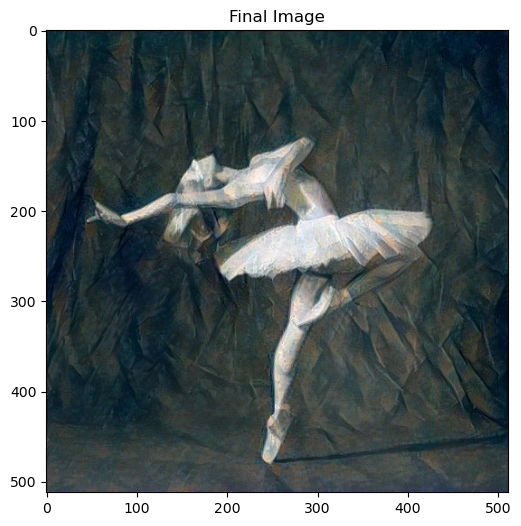

In [5]:
final_img = model.var_img.detach().cpu().numpy()
plt.figure(figsize=(12, 6))
plt.imshow(np.transpose(final_img, axes=(1, 2, 0))[:, :, ::-1])
plt.title("Final Image")
plt.show()